<a href="https://colab.research.google.com/github/VivoSorhie/Telecom-Customer-Churn-Segmentation-Analysis/blob/main/Teleco_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom Customer Churn & Segmentation Analysis

**Objective:** To analyze customer data to identify distinct user groups and predict churn, enabling targeted retention strategies.

In [2]:
# --- Core Libraries for Data Handling ---
import pandas as pd
import numpy as np
import warnings

# --- Libraries for Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Libraries for Machine Learning ---

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Segmentation Model
from sklearn.cluster import KMeans

# Churn Prediction Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Colab Specific for File Handling ---
from google.colab import files
import io

# --- Settings ---
# Ignore warnings to keep the output clean
warnings.filterwarnings('ignore')
# Set a default style for all our plots
sns.set_style('whitegrid')

print("All necessary libraries have been imported successfully!")

All necessary libraries have been imported successfully!


In [3]:
files.upload()

Saving train.csv to train.csv


{'train.csv': b'state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn\r\nOH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,no\r\nNJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.3,162.6,104,7.32,12.2,5,3.29,0,no\r\nOH,84,area_code_408,yes,no,0,299.4,71,50.9,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no\r\nOK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no\r\nMA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no\r\nMO,147,area_code_415,yes,no,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,no\r\nLA,117,area_code_408,no,no,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4

Load and inspect data

In [4]:
df = pd.read_csv('train.csv')

In [5]:
print('First 5 rows:')
print(df.head())
print('Dataset shape:')
print(f"Rows:{df.shape[0]}, Columns:{df.shape[1]}")
print('Datatype and nulls')
print(df.info())
print(df.isnull().sum().sort_values(ascending=False))

First 5 rows:
  state  account_length      area_code international_plan voice_mail_plan  \
0    OH             107  area_code_415                 no             yes   
1    NJ             137  area_code_415                 no              no   
2    OH              84  area_code_408                yes              no   
3    OK              75  area_code_415                yes              no   
4    MA             121  area_code_510                 no             yes   

   number_vmail_messages  total_day_minutes  total_day_calls  \
0                     26              161.6              123   
1                      0              243.4              114   
2                      0              299.4               71   
3                      0              166.7              113   
4                     24              218.2               88   

   total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
0             27.47              195.5              103      

## 2. Data Cleaning and Feature Preprocessing

Based on our initial inspection, the data is very clean with no missing values. However, we have several columns with `object` data types that need to be converted into a numerical format for our models.

Our plan is as follows:
1.  **Encode Binary Features:** Convert columns with 'yes'/'no' values (`international_plan`, `voice_mail_plan`, `churn`) into `1` and `0`.
2.  **Investigate Redundant Features:** The `total_..._minutes` and `total_..._charge` columns seem to be directly related. We'll verify this and drop the redundant ones to simplify our model.
3.  **Handle Categorical Features:** We will examine `state` and `area_code` to decide if they are useful for our model.


---



**1. Convert binary features**

What we're doing: We are converting the 'yes'/'no' string values into integers (1 for 'yes', 0 for 'no').

In [6]:
#List of columns to conver from Yes/No to 1/0
binary_cols = ['international_plan', 'voice_mail_plan', 'churn']
for col in binary_cols:
  df[col]= df[col].replace({'no': 0, 'yes': 1})
print("Binary columns converted successfully.")
print("\nFirst 5 rows with converted columns:")
print(df[['international_plan', 'voice_mail_plan', 'churn']].head())

Binary columns converted successfully.

First 5 rows with converted columns:
   international_plan  voice_mail_plan  churn
0                   0                1      0
1                   0                0      0
2                   1                0      0
3                   1                0      0
4                   0                1      0


**2. Investigate Redundant Features (Minutes vs. Charges) and check correlation**

What we're doing: We suspect that call charges are calculated directly from call minutes. If they are perfectly correlated, we should remove one of each pair to avoid multicollinearity.

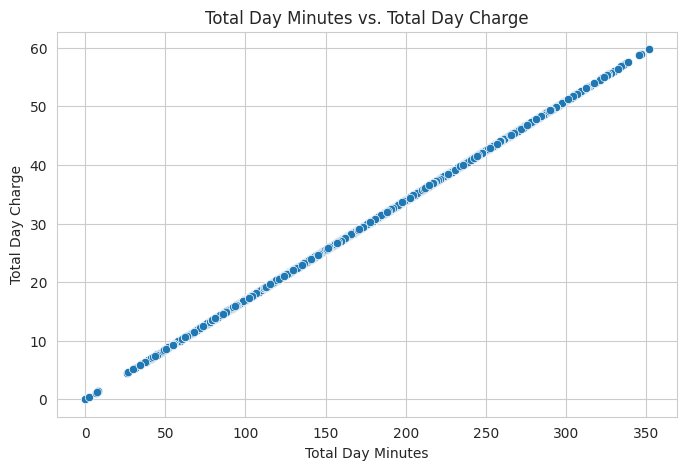


Correlation between total_day_minutes and total_day_charge: 1.0000


In [7]:
# Create a scatter plot to see the relationship between total day minutes and charge
plt.figure(figsize=(8, 5))
sns.scatterplot(x='total_day_minutes', y='total_day_charge', data=df)
plt.title('Total Day Minutes vs. Total Day Charge')
plt.xlabel('Total Day Minutes')
plt.ylabel('Total Day Charge')
plt.show()

# Let's also check the correlation coefficient
correlation = df['total_day_minutes'].corr(df['total_day_charge'])
print(f"\nCorrelation between total_day_minutes and total_day_charge: {correlation:.4f}")

**Drop Unnecessary Columns**

Action: Remove the charge columns, state, and area_code.

Reason:

* The charge columns are redundant (as confirmed in previous cell).
* (`state`) has too many unique values (high cardinality), which can complicate modeling.
* We'll start without it to build a more general model.
`area_code` is also a categorical feature we will exclude for now.

In [8]:
# List of columns to drop
# We drop the charge columns as they are redundant with minutes.
# We drop state and area_code to create a more general model.
cols_to_drop = [
    'total_day_charge', 'total_eve_charge',
    'total_night_charge', 'total_intl_charge',
    'state', 'area_code'
]

df_cleaned = df.drop(columns=cols_to_drop)

print("Dropped unnecessary columns.")
print(f"\nNew dataset shape: {df_cleaned.shape}")

print("\n--- Cleaned DataFrame Head ---")
print(df_cleaned.head())

Dropped unnecessary columns.

New dataset shape: (4250, 14)

--- Cleaned DataFrame Head ---
   account_length  international_plan  voice_mail_plan  number_vmail_messages  \
0             107                   0                1                     26   
1             137                   0                0                      0   
2              84                   1                0                      0   
3              75                   1                0                      0   
4             121                   0                1                     24   

   total_day_minutes  total_day_calls  total_eve_minutes  total_eve_calls  \
0              161.6              123              195.5              103   
1              243.4              114              121.2              110   
2              299.4               71               61.9               88   
3              166.7              113              148.3              122   
4              218.2               8

## 3. Exploratory Data Analysis (EDA)

* **Objective:** To visually explore the data and uncover insights about customer churn.
* **Key Questions:**
    1.  What is the overall churn rate in our dataset?
    2.  How do numerical features (like call minutes and service calls) differ between customers who churn and those who don't?
    3.  Are customers with special plans (International, Voicemail) more or less likely to churn?

---



**Analyze the Overall Churn Rate**

Action: Create a count plot to visualize the distribution of the `churn` variable.

Reason: To understand the class balance. A highly imbalanced dataset (e.g., 95% non-churn, 5% churn) might require special techniques during modeling.

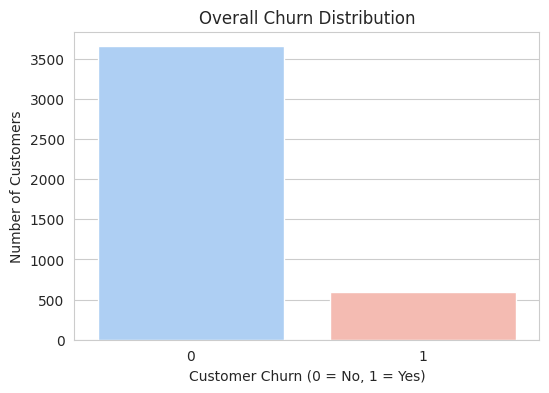

Churn Rate:
churn
0    85.93
1    14.07
Name: proportion, dtype: float64


In [9]:
plt.figure(figsize=(6, 4))

# Use consistent pastel colors for [No Churn, Churn]
pastel_colors = ["#a2cffe", "#ffb3a7"]

sns.countplot(
    x='churn',
    data=df_cleaned,
    palette=pastel_colors
)

plt.title('Overall Churn Distribution')
plt.xlabel('Customer Churn (0 = No, 1 = Yes)')
plt.ylabel('Number of Customers')
plt.show()

# Calculate the exact percentage
churn_rate = df_cleaned['churn'].value_counts(normalize=True) * 100
print(f"Churn Rate:\n{churn_rate.round(2)}")




---

**Churn vs customer frustration**
* **Next Question:** Is there a link between customer frustration and churn?
* **Analysis:** Let's compare `number_customer_service_calls` for churners vs. non-churners.

Text(0.5, 0, 'Number of Customer Service')

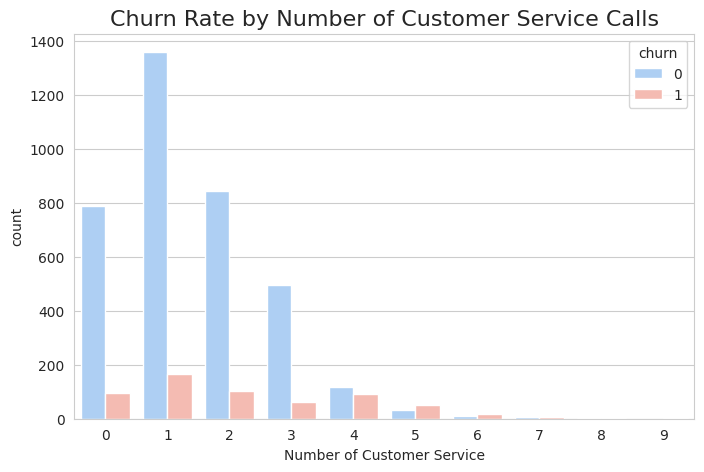

In [10]:
plt.figure(figsize=(8, 5))

# Define pastel color palette for churn status
pastel_colors = ["#a2cffe", "#ffb3a7"]  # [No Churn, Churn]

# Use countplot with appropriate colors
sns.countplot(
    x='number_customer_service_calls',
    hue='churn',
    data=df_cleaned,
    palette=pastel_colors
)

plt.title('Churn Rate by Number of Customer Service Calls', fontsize=16)
plt.xlabel('Number of Customer Service')


* Clear Pattern: Look at the bars from left to right. For customers with 0, 1, 2, or 3 service calls, the blue bar (No Churn) is much larger than the orange bar (Churn).

* The Tipping Point: At 4 calls, the no churn rate dramatically decreases. For customers who make 4 or more calls, churning becomes the more likely outcome.

* Actionable Insight: This is a goldmine. The number of customer service calls is a powerful predictor of churn. The business should flag any customer who makes their 4th call as being at extremely high risk and potentially intervene immediately.



---

**Churn vs. International Plan**

Action: Create a count plot to visualize churn for customers based on whether they have an international plan.

Reason: This will tell us if this specific product offering is related to higher or lower customer churn.

---



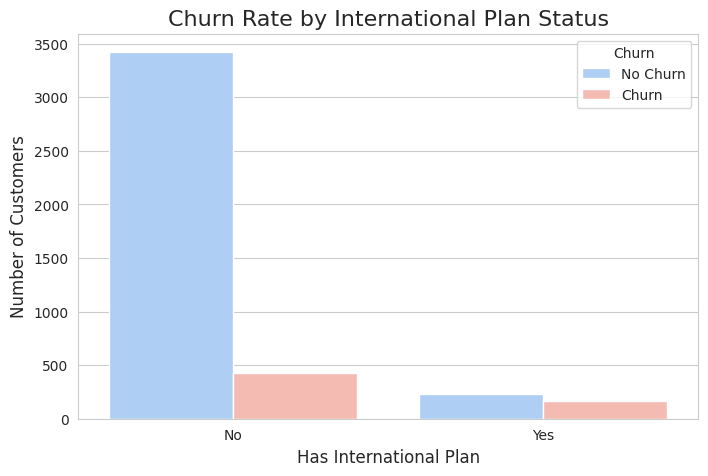

In [11]:
plt.figure(figsize=(8, 5))

# Define the same pastel color palette
pastel_colors = ["#a2cffe", "#ffb3a7"]  # [No Churn, Churn]

# Use a countplot with pastel colors for each hue group
sns.countplot(
    x='international_plan',
    hue='churn',
    data=df_cleaned,
    palette=pastel_colors
)

plt.title('Churn Rate by International Plan Status', fontsize=16)
plt.xlabel('Has International Plan', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.legend(title='Churn', labels=['No Churn', 'Churn'])
plt.show()


**Churn vs. Daily Usage**
* **Question:** Do customers who churn have different daily usage patterns?
* **Analysis:** Let's compare `total_day_minutes` for churners vs. non-churners using a box plot.

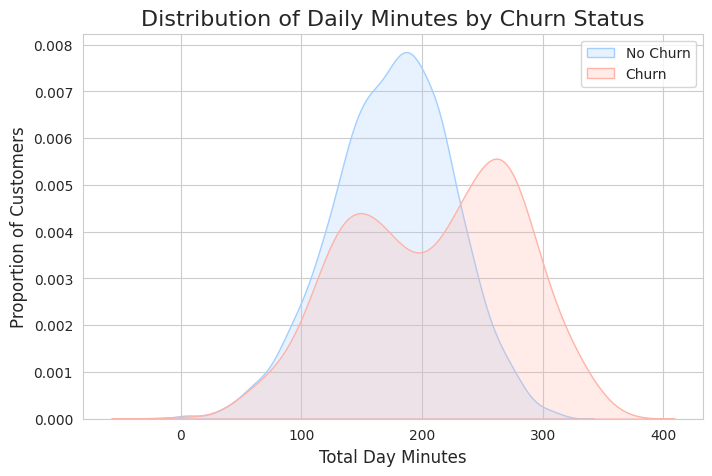

In [12]:
# Set a slightly smaller, more appropriate figure size
plt.figure(figsize=(8, 5))

# Define a pastel color palette
pastel_colors = {"No Churn": "#a2cffe", "Churn": "#ffb3a7"}

# Plot the density for customers who did NOT churn
sns.kdeplot(df_cleaned[df_cleaned['churn'] == 0]['total_day_minutes'],
            label='No Churn', color=pastel_colors["No Churn"], fill=True)

# Plot the density for customers who DID churn
sns.kdeplot(df_cleaned[df_cleaned['churn'] == 1]['total_day_minutes'],
            label='Churn', color=pastel_colors["Churn"], fill=True)

plt.title('Distribution of Daily Minutes by Churn Status', fontsize=16)
plt.xlabel('Total Day Minutes', fontsize=12)
plt.ylabel('Proportion of Customers', fontsize=12) # <-- The corrected, intuitive label
plt.legend()
plt.show()

Business Implication
This isn't just a statistical difference; it's a critical business signal. It could mean several things:

* Your most active customers might be the most sensitive to pricing or network quality.

* Competitors might be specifically targeting these high-value users with better offers.

* These could be business users whose needs are not being fully met.



---
##Final Insights after EDA
International plan:
Churn rates are comparable for customers with and without an international plan.

Customer service calls:
Churn risk spikes after 3 calls; at 4+ calls customers are likely to leave.

High daily usage:
Heavy users churn more, likely due to plan mismatch or perceived poor value.


---



# 4. Customer Segmentation with K-Means

* **Objective:** To identify distinct customer groups (personas) based on their usage patterns and behaviors.
* **Method:** We will use K-Means clustering. This requires two key steps before we can analyze the results:
    1.  **Feature Scaling:** Standardize all numerical features so they are on the same scale.
    2.  **Finding the Optimal Number of Clusters (k):** Use the "Elbow Method" to determine the best number of segments.

In [13]:
from sklearn.preprocessing import StandardScaler

# Create a copy of the cleaned dataframe for segmentation
# We drop 'churn' as this is unsupervised - we're only looking at behavior
df_seg = df_cleaned.drop('churn', axis=1)

# Select only the numerical columns to scale
numerical_cols = df_seg.select_dtypes(include=['int64', 'float64']).columns

# Initialize the scaler and fit it to our data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_seg[numerical_cols])

# Convert the scaled array back to a DataFrame for easier use
df_scaled = pd.DataFrame(df_scaled, columns=numerical_cols)

print("Data has been scaled successfully.")
print("\n--- First 5 Rows of Scaled Data ---")
print(df_scaled.head())

Data has been scaled successfully.

--- First 5 Rows of Scaled Data ---
   account_length  international_plan  voice_mail_plan  number_vmail_messages  \
0        0.170399           -0.320547         1.679864               1.366857   
1        0.926186           -0.320547        -0.595286              -0.567911   
2       -0.409038            3.119667        -0.595286              -0.567911   
3       -0.635774            3.119667        -0.595286              -0.567911   
4        0.523099           -0.320547         1.679864               1.218029   

   total_day_minutes  total_day_calls  total_eve_minutes  total_eve_calls  \
0          -0.345510         1.163449          -0.093025         0.141841   
1           1.169136         0.710014          -1.571820         0.493490   
2           2.206058        -1.456398          -2.752070        -0.611691   
3          -0.251076         0.659633          -1.032448         1.096316   
4           0.702522        -0.599910           2.952139

In [ ]:
# --- Step 2: Preparing Data for Segmentation ---

from sklearn.preprocessing import StandardScaler

# 1. Select the features that describe customer behavior for clustering.
# We are focusing on numeric features that represent usage and interaction patterns.
features_for_clustering = [
    'account_length',
    'number_vmail_messages',
    'total_day_minutes',
    'total_day_calls',
    'total_eve_minutes',
    'total_eve_calls',
    'total_night_minutes',
    'total_night_calls',
    'total_intl_minutes',
    'total_intl_calls',
    'number_customer_service_calls',
    'total_minutes',  # Our new engineered feature
    'minutes_per_call' # Our new engineered feature
]

# Create the subset of data for clustering
X_for_clustering = df_engineered[features_for_clustering]

# 2. Standardize the features
# This is crucial for K-Means to work correctly.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_for_clustering)

# --- Verification ---
print("--- Data Preparation for Segmentation Complete ---")
print(f"Shape of the data to be clustered: {X_scaled.shape}")
print("\nPreview of the first 5 rows of the scaled data:")
# We use a pandas DataFrame for prettier printing of the preview
print(pd.DataFrame(X_scaled, columns=features_for_clustering).head())


--- Data Preparation for Segmentation Complete ---
Shape of the data to be clustered: (4250, 13)

Preview of the first 5 rows of the scaled data:
   account_length  number_vmail_messages  total_day_minutes  total_day_calls  \
0        0.170399               1.366857          -0.345510         1.163449   
1        0.926186              -0.567911           1.169136         0.710014   
2       -0.409038              -0.567911           2.206058        -1.456398   
3       -0.635774              -0.567911          -0.251076         0.659633   
4        0.523099               1.218029           0.702522        -0.599910   

   total_eve_minutes  total_eve_calls  total_night_minutes  total_night_calls  \
0          -0.093025         0.141841             1.070003           0.157309   
1          -1.571820         0.493490            -0.753320           0.207083   
2          -2.752070        -0.611691            -0.072057          -0.539526   
3          -1.032448         1.096316            

* **Next Step:** Find the optimal number of customer segments using the **Elbow Method**.
* **How it works:** We'll plot the clustering performance for different numbers of clusters (k). The "elbow" of the curve on the plot will indicate the most logical number of segments.

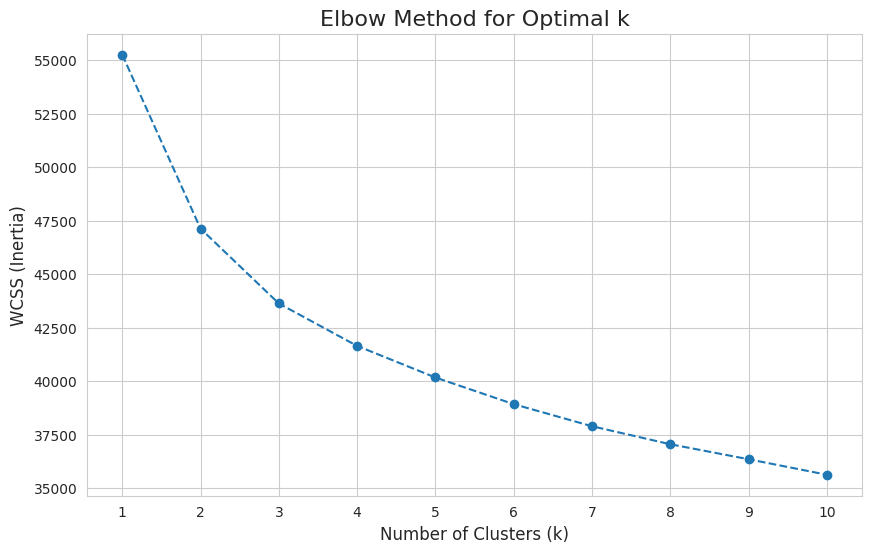

In [14]:
from sklearn.cluster import KMeans

# WCSS = Within-Cluster Sum of Squares (a.k.a. inertia)
wcss = []
k_range = range(1, 11) # We will test k from 1 to 10

# Loop through each number of clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_) # inertia_ is the WCSS

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('WCSS (Inertia)', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

* **Final Step:** Build the K-Means model using our optimal k=3.
* **Outcome:** Assign each customer to one of the three segments and add this information back to our main dataframe for analysis.

---

Running K-Means with k=3 and Assigning Labels
Action: We will instantiate and fit the KMeans model with n_clusters=3. Then, we create a new cluster column in our df_cleaned dataframe.

Reason: This is the final step of the clustering process. The output will be our original dataframe, now enriched with a new column that tells us which segment each customer belongs to.

---



In [15]:
# Initialize KMeans with our optimal k=3
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)

# Fit the model to our scaled data and get the cluster labels
cluster_labels = kmeans.fit_predict(df_scaled)

# Add the cluster labels back to our original (unscaled) cleaned dataframe
# This is crucial for interpreting the results in their original units (e.g., minutes)
df_cleaned['cluster'] = cluster_labels

print("K-Means model built and cluster labels assigned successfully.")

print("\n--- First 5 Rows with Cluster Labels ---")
print(df_cleaned.head())

print("\n--- Number of Customers in Each Cluster ---")
print(df_cleaned['cluster'].value_counts())

K-Means model built and cluster labels assigned successfully.

--- First 5 Rows with Cluster Labels ---
   account_length  international_plan  voice_mail_plan  number_vmail_messages  \
0             107                   0                1                     26   
1             137                   0                0                      0   
2              84                   1                0                      0   
3              75                   1                0                      0   
4             121                   0                1                     24   

   total_day_minutes  total_day_calls  total_eve_minutes  total_eve_calls  \
0              161.6              123              195.5              103   
1              243.4              114              121.2              110   
2              299.4               71               61.9               88   
3              166.7              113              148.3              122   
4              218.2    

## 5. Analysis of Customer Segments

* **Objective:** To understand the distinct characteristics of each of our three customer segments.
* **Method:** We will group the data by the new `cluster` label and calculate the average for each feature. This will allow us to create a clear profile or "persona" for each customer group.

In [16]:
# Group by the 'cluster' column and calculate the mean for each feature
segment_analysis = df_cleaned.groupby('cluster').mean()

# Display the summary table
print("--- Average Characteristics of Each Customer Segment ---")
print(segment_analysis)

--- Average Characteristics of Each Customer Segment ---
         account_length  international_plan  voice_mail_plan  \
cluster                                                        
0            103.585859                 1.0         0.262626   
1             99.953268                 0.0         0.000000   
2             99.719246                 0.0         1.000000   

         number_vmail_messages  total_day_minutes  total_day_calls  \
cluster                                                              
0                     7.833333         187.008838       100.512626   
1                     0.000000         179.563668       100.046732   
2                    29.100198         179.573016        99.275794   

         total_eve_minutes  total_eve_calls  total_night_minutes  \
cluster                                                            
0               203.854798        99.989899           197.277525   
1               199.360190       100.176037           200.404076   

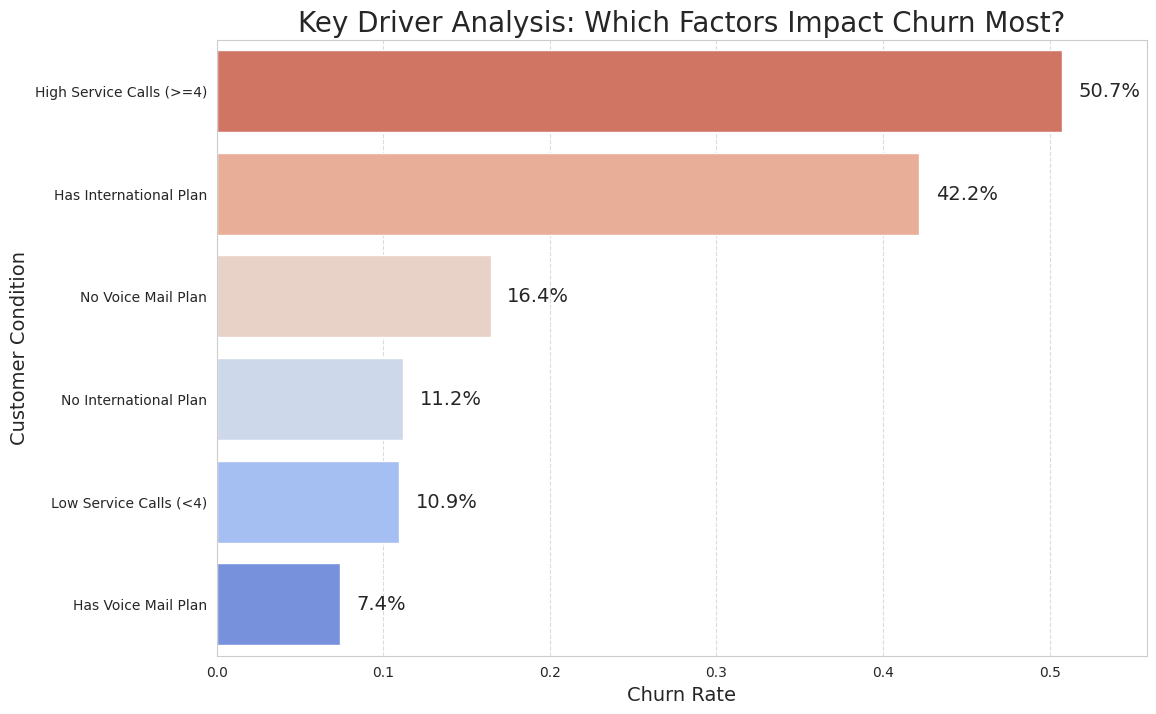

In [22]:
# --- Data Preparation for the Chart ---
# We will create a summary of churn rates for different conditions

# 1. International Plan
churn_intl_yes = df_cleaned[df_cleaned['international_plan'] == 1]['churn'].mean()
churn_intl_no = df_cleaned[df_cleaned['international_plan'] == 0]['churn'].mean()

# 2. Voice Mail Plan
churn_vm_yes = df_cleaned[df_cleaned['voice_mail_plan'] == 1]['churn'].mean()
churn_vm_no = df_cleaned[df_cleaned['voice_mail_plan'] == 0]['churn'].mean()

# 3. High Customer Service Calls (The tipping point we found was >= 4)
churn_serv_high = df_cleaned[df_cleaned['number_customer_service_calls'] >= 4]['churn'].mean()
churn_serv_low = df_cleaned[df_cleaned['number_customer_service_calls'] < 4]['churn'].mean()

# Create a DataFrame to hold these findings
df_drivers = pd.DataFrame({
    'Condition': [
        'Has International Plan', 'High Service Calls (>=4)',
        'No Voice Mail Plan', 'Low Service Calls (<4)',
        'No International Plan', 'Has Voice Mail Plan'
    ],
    'Churn Rate': [
        churn_intl_yes, churn_serv_high,
        churn_vm_no, churn_serv_low,
        churn_intl_no, churn_vm_yes
    ]
}).sort_values('Churn Rate', ascending=False)


# --- Create the Visualization ---
plt.figure(figsize=(12, 8))
# Create the bar plot
barplot = sns.barplot(
    x='Churn Rate',
    y='Condition',
    data=df_drivers,
    palette='coolwarm_r' # Red for high churn, Blue for low churn
)

# Add annotations (the exact percentage) to each bar
for p in barplot.patches:
    width = p.get_width()
    plt.text(width + 0.01,  # Position text slightly outside the bar
             p.get_y() + p.get_height() / 2,
             f'{width:.1%}', # Format as percentage
             va='center',
             fontsize=14)

# Style the plot
plt.title('Key Driver Analysis: Which Factors Impact Churn Most?', fontsize=20)
plt.xlabel('Churn Rate', fontsize=14)
plt.ylabel('Customer Condition', fontsize=14)
plt.xlim(0, max(df_drivers['Churn Rate']) * 1.1) # Give space for text
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
1,NJ,137,area_code_415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
2,OH,84,area_code_408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
3,OK,75,area_code_415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
4,MA,121,area_code_510,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0


In [23]:
# Initialize KMeans with our optimal k=3
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)

# Fit the model and get the cluster labels
cluster_labels = kmeans.fit_predict(df_scaled)

# Add the labels back to our main cleaned dataframe
df_cleaned['cluster'] = cluster_labels

print("Cluster labels assigned successfully.")

Cluster labels assigned successfully.


In [24]:
# Group by cluster and calculate the mean
segment_analysis = df_cleaned.groupby('cluster').mean()

print("--- Average Characteristics of Each Customer Segment ---")
print(segment_analysis)

--- Average Characteristics of Each Customer Segment ---
         account_length  international_plan  voice_mail_plan  \
cluster                                                        
0            103.585859                 1.0         0.262626   
1             99.953268                 0.0         0.000000   
2             99.719246                 0.0         1.000000   

         number_vmail_messages  total_day_minutes  total_day_calls  \
cluster                                                              
0                     7.833333         187.008838       100.512626   
1                     0.000000         179.563668       100.046732   
2                    29.100198         179.573016        99.275794   

         total_eve_minutes  total_eve_calls  total_night_minutes  \
cluster                                                            
0               203.854798        99.989899           197.277525   
1               199.360190       100.176037           200.404076   

The Conclusion: Our Three Customer Personas
By combining these insights, we can now give each cluster a meaningful name and story.

**Cluster 0**: "The At-Risk International Segment"

* They are defined by: 100% have an international plan.

* Their behavior is: They have the highest churn rate at 42.2%.

* The Story: This is a small but extremely high-risk group. The international plan is strongly associated with them leaving.

---



**Cluster 2**: "The Loyal Core"

* They are defined by: 100% have a voice mail plan.

* Their behavior is: They are very loyal, with the lowest churn rate at only 4.8%.

* The Story: These are your most stable, low-risk customers. The voice mail plan is a feature of your most loyal base.

---



**Cluster 1**: "The Standard Customer"

* They are defined by: They have neither of the special plans.

* Their behavior is: Their churn rate of 13.5% is average.

* The Story: This is your baseline, everyday customer. They are the largest group, and their behavior represents the company average.

# 7. Churn Prediction Modeling

* **Objective:** To build a machine learning model that can predict the likelihood of an individual customer churning.
* **Our Plan:**
    1.  Separate our data into features (X) and the target variable (y).
    2.  Split the data into training and testing sets.
    3.  Train our first classification model.

In [26]:
from sklearn.model_selection import train_test_split

# Define our features (X) and target (y)
# We drop 'cluster' because we want the model to learn from the original features, not our created segments.
X = df_cleaned.drop(['churn', 'cluster'], axis=1)
y = df_cleaned['churn']

# Split the data into training (80%) and testing (20%) sets
# random_state ensures the same split for reproducibility
# stratify=y ensures the proportion of churners is the same in both the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data successfully split into training and testing sets.")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"\nChurn proportion in training set:\n{y_train.value_counts(normalize=True).round(2)}")
print(f"\nChurn proportion in testing set:\n{y_test.value_counts(normalize=True).round(2)}")

Data successfully split into training and testing sets.
Training set shape: (3400, 13)
Testing set shape: (850, 13)

Churn proportion in training set:
churn
0    0.86
1    0.14
Name: proportion, dtype: float64

Churn proportion in testing set:
churn
0    0.86
1    0.14
Name: proportion, dtype: float64


### Model 1: Logistic Regression

* **Objective:** To train a baseline model to predict churn.
* **First step:** We must scale our features. This is essential for models like Logistic Regression to perform correctly.
* **Second step:** We will train the model on the scaled training data.

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# --- Scale the Features ---
# We fit the scaler ONLY on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# We use the same scaler to transform the test data
X_test_scaled = scaler.transform(X_test)


# --- Train the Logistic Regression Model ---
# Initialize the model
log_reg = LogisticRegression(random_state=42)

# Train the model on the scaled training data
log_reg.fit(X_train_scaled, y_train)

print("Logistic Regression model trained successfully!")

Logistic Regression model trained successfully!


--- Classification Report ---
              precision    recall  f1-score   support

    No Churn       0.88      0.96      0.92       730
       Churn       0.44      0.19      0.27       120

    accuracy                           0.85       850
   macro avg       0.66      0.58      0.59       850
weighted avg       0.82      0.85      0.83       850


--- Confusion Matrix ---


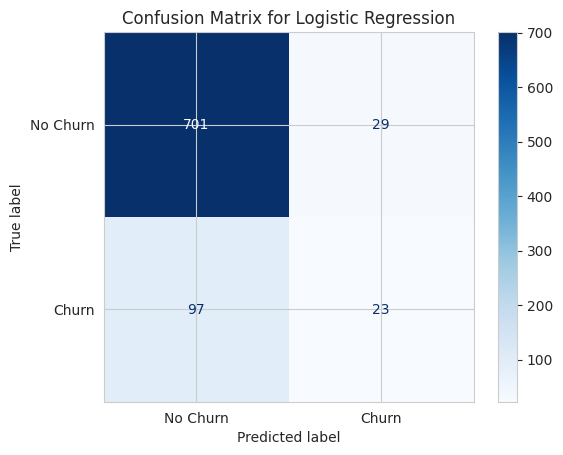

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Use the trained model to make predictions on the test data
y_pred = log_reg.predict(X_test_scaled)

# --- Generate the Classification Report ---
print("--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))


# --- Generate and Display the Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)

# For a more visual representation
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

### Model 2: Improving Predictions with a Random Forest

* **Problem:** Our baseline Logistic Regression model had very low recall, failing to identify most churners.
* **Solution:** We will now train a more powerful **Random Forest Classifier**. This model is often better at detecting complex patterns and can improve our ability to find the customers who are at risk of leaving.

In [29]:
from sklearn.ensemble import RandomForestClassifier

# --- Train the Random Forest Model ---
# Initialize the model with random_state for reproducibility
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the same scaled training data
rf_model.fit(X_train_scaled, y_train)

print("Random Forest model trained successfully!")

Random Forest model trained successfully!


--- Classification Report for Random Forest ---
              precision    recall  f1-score   support

    No Churn       0.95      1.00      0.98       730
       Churn       1.00      0.69      0.82       120

    accuracy                           0.96       850
   macro avg       0.98      0.85      0.90       850
weighted avg       0.96      0.96      0.95       850


--- Confusion Matrix for Random Forest ---


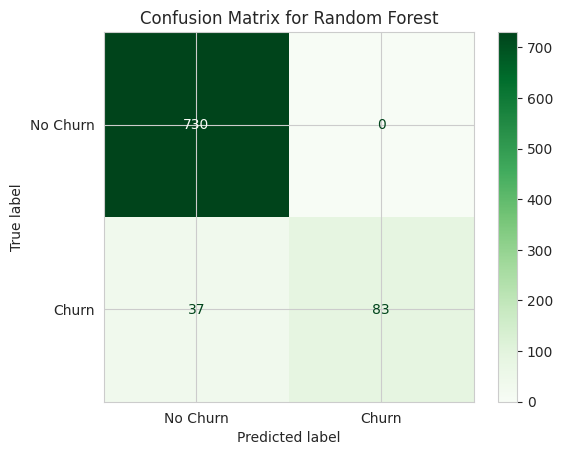

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Use the trained Random Forest model to make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# --- Generate the Classification Report ---
print("--- Classification Report for Random Forest ---")
print(classification_report(y_test, y_pred_rf, target_names=['No Churn', 'Churn']))


# --- Generate and Display the Confusion Matrix ---
print("\n--- Confusion Matrix for Random Forest ---")
cm_rf = confusion_matrix(y_test, y_pred_rf)

# For a more visual representation
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['No Churn', 'Churn'])
disp_rf.plot(cmap=plt.cm.Greens) # Use a different color to distinguish from the last one
plt.title("Confusion Matrix for Random Forest")
plt.show()

In [34]:
from sklearn.metrics import classification_report

# Get the predicted probabilities for the 'Churn' class (class 1)
y_pred_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

# Set our new, lower threshold
new_threshold = 0.30

# Classify based on the new threshold
y_pred_tuned = (y_pred_probs >= new_threshold).astype(int)


# --- Generate the NEW Classification Report ---
print(f"--- Classification Report with {new_threshold*100}% Threshold ---")
print(classification_report(y_test, y_pred_tuned, target_names=['No Churn', 'Churn']))

--- Classification Report with 30.0% Threshold ---
              precision    recall  f1-score   support

    No Churn       0.97      0.96      0.96       730
       Churn       0.77      0.80      0.78       120

    accuracy                           0.94       850
   macro avg       0.87      0.88      0.87       850
weighted avg       0.94      0.94      0.94       850



In [35]:
from sklearn.metrics import classification_report

# Get the predicted probabilities for the 'Churn' class (class 1)
y_pred_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

# Set our new, lower threshold
new_threshold = 0.40

# Classify based on the new threshold
y_pred_tuned = (y_pred_probs >= new_threshold).astype(int)


# --- Generate the NEW Classification Report ---
print(f"--- Classification Report with {new_threshold*100}% Threshold ---")
print(classification_report(y_test, y_pred_tuned, target_names=['No Churn', 'Churn']))

--- Classification Report with 40.0% Threshold ---
              precision    recall  f1-score   support

    No Churn       0.96      0.99      0.98       730
       Churn       0.95      0.75      0.84       120

    accuracy                           0.96       850
   macro avg       0.95      0.87      0.91       850
weighted avg       0.96      0.96      0.96       850



# 8. Feature Importance Analysis

* **Objective:** To understand which customer attributes our Random Forest model found to be the most predictive of churn.
* **Method:** We will extract the feature importance scores from our trained model and visualize them. This tells us the "why" behind the model's accurate predictions and confirms our initial findings.

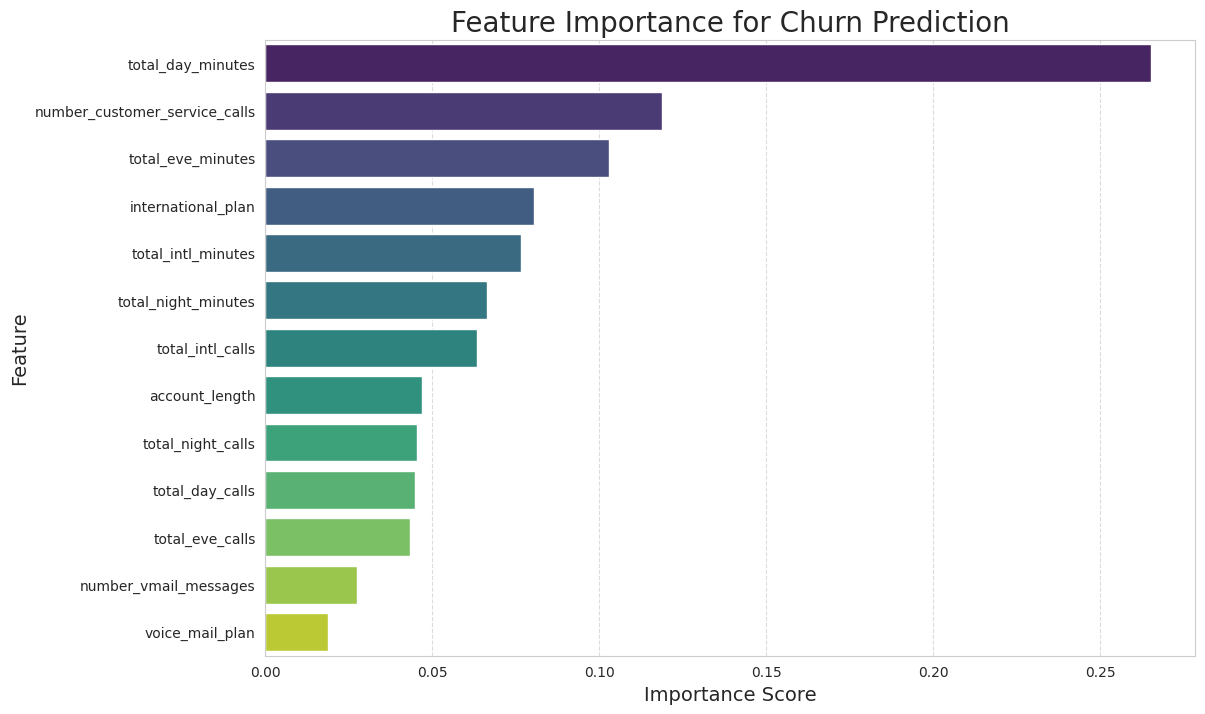

In [37]:
# Extract feature importances from the trained Random Forest model
importances = rf_model.feature_importances_
features = X_train.columns

# Create a DataFrame for easier visualization
df_importance = pd.DataFrame({'feature': features, 'importance': importances})
df_importance = df_importance.sort_values('importance', ascending=False)


# --- Create the Visualization ---
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=df_importance, palette='viridis')

plt.title('Feature Importance for Churn Prediction', fontsize=20)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#Some more visualisations

## 1. Churn Probability Histogram.

* **Objective:** To create a suite of advanced visualizations that prove our model's effectiveness and justify our choice of the 40% threshold.
* The Churn Probability Histogram**. This chart is the best way to visually confirm that our model is confidently separating at-risk customers from safe ones.

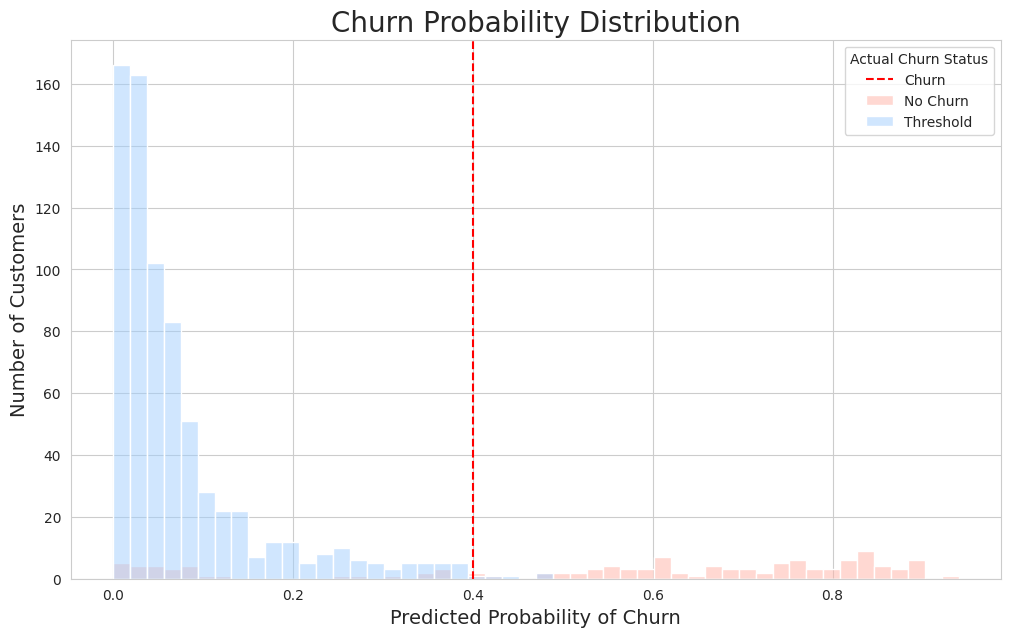

In [38]:
# Create a DataFrame with the true churn status and the predicted probabilities
df_probs = pd.DataFrame({
    'true_churn': y_test,
    'predicted_probability': rf_model.predict_proba(X_test_scaled)[:, 1] # Probability of churn (class 1)
})

# --- Create the Visualization ---
plt.figure(figsize=(12, 7))
# Plot the two histograms
sns.histplot(data=df_probs, x='predicted_probability', hue='true_churn',
             multiple='layer', bins=50, palette={0: '#a2cffe', 1: '#ffb3a7'})

# Add a vertical line at our chosen 40% threshold
plt.axvline(x=0.4, color='red', linestyle='--', label='Chosen Threshold (40%)')

# Style the plot
plt.title('Churn Probability Distribution', fontsize=20)
plt.xlabel('Predicted Probability of Churn', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.legend(title='Actual Churn Status', labels=['Churn', 'No Churn', 'Threshold'])
plt.show()

##2. **The ROC Curve & AUC Score**.
* **Objective:** To get a single, standard score that measures our model's ability to distinguish between churners and non-churners across all possible thresholds.
* **What to look for:** A curve that bows up towards the top-left corner and an AUC score close to 1.0.

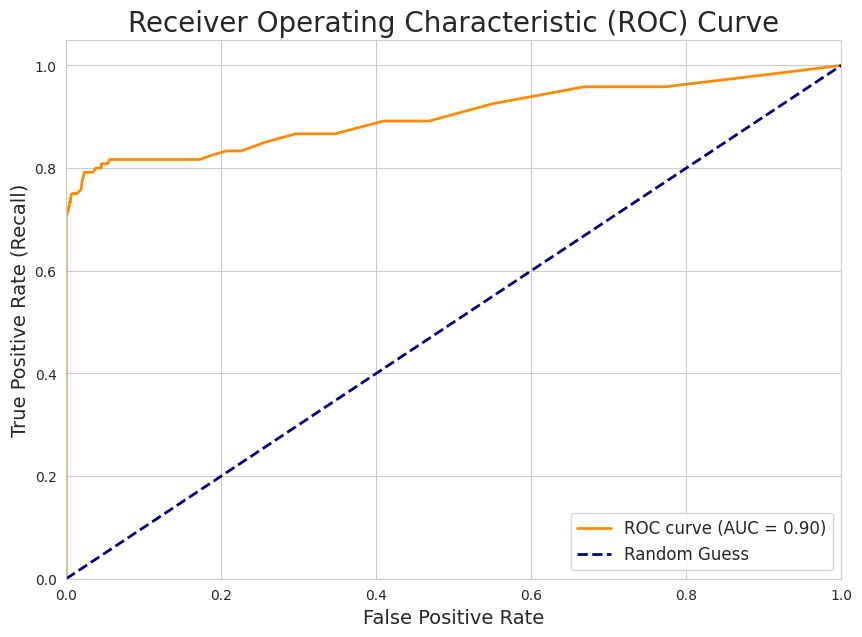

The Area Under the Curve (AUC) for our model is: 0.90


In [39]:
from sklearn.metrics import roc_curve, auc

# We already have our predicted probabilities from the last step
# y_pred_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate the points for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)


# --- Create the Visualization ---
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# Plot the "random guess" line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Style the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate (Recall)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

print(f"The Area Under the Curve (AUC) for our model is: {roc_auc:.2f}")

## 3. The Precision-Recall Curve
* **Objective:** To visualize the trade-off between finding churners (Recall) and being accurate (Precision). For imbalanced datasets, this is often the most important evaluation curve.
* **What to look for:** A curve that stays high and close to the top-right corner.

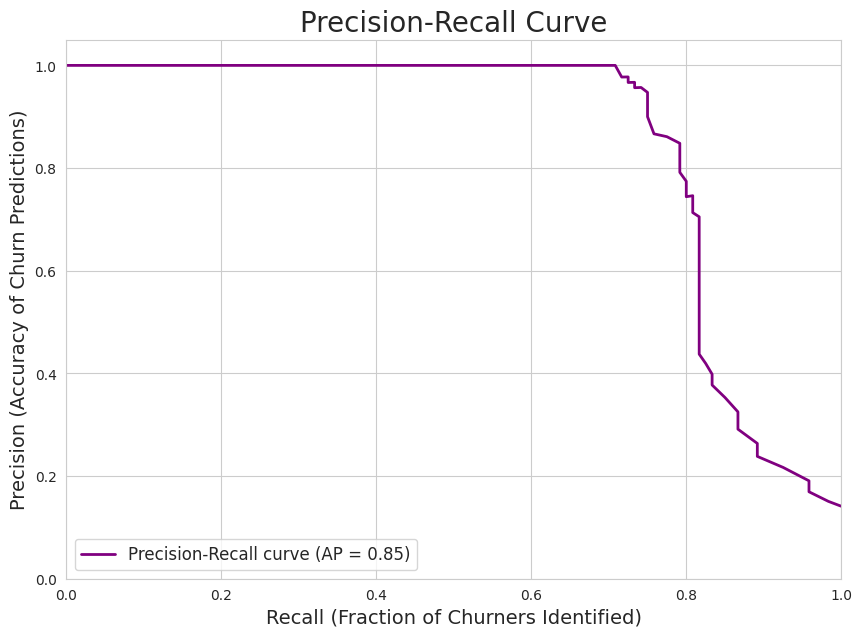

The Average Precision (AP) for our model is: 0.85


In [40]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# We already have our predicted probabilities
# y_pred_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate the points for the Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Calculate the Average Precision score
avg_precision = average_precision_score(y_test, y_pred_probs)


# --- Create the Visualization ---
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, color='purple', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')

# Style the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Fraction of Churners Identified)', fontsize=14)
plt.ylabel('Precision (Accuracy of Churn Predictions)', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=20)
plt.legend(loc="lower left", fontsize=12)
plt.grid(True)
plt.show()

print(f"The Average Precision (AP) for our model is: {avg_precision:.2f}")

## 3. Confusion Matrix Heatmap Comparison**.
* **Objective:** To create a visual dashboard that shows the concrete impact of changing our decision threshold. This makes the precision-recall trade-off easy for anyone to understand.

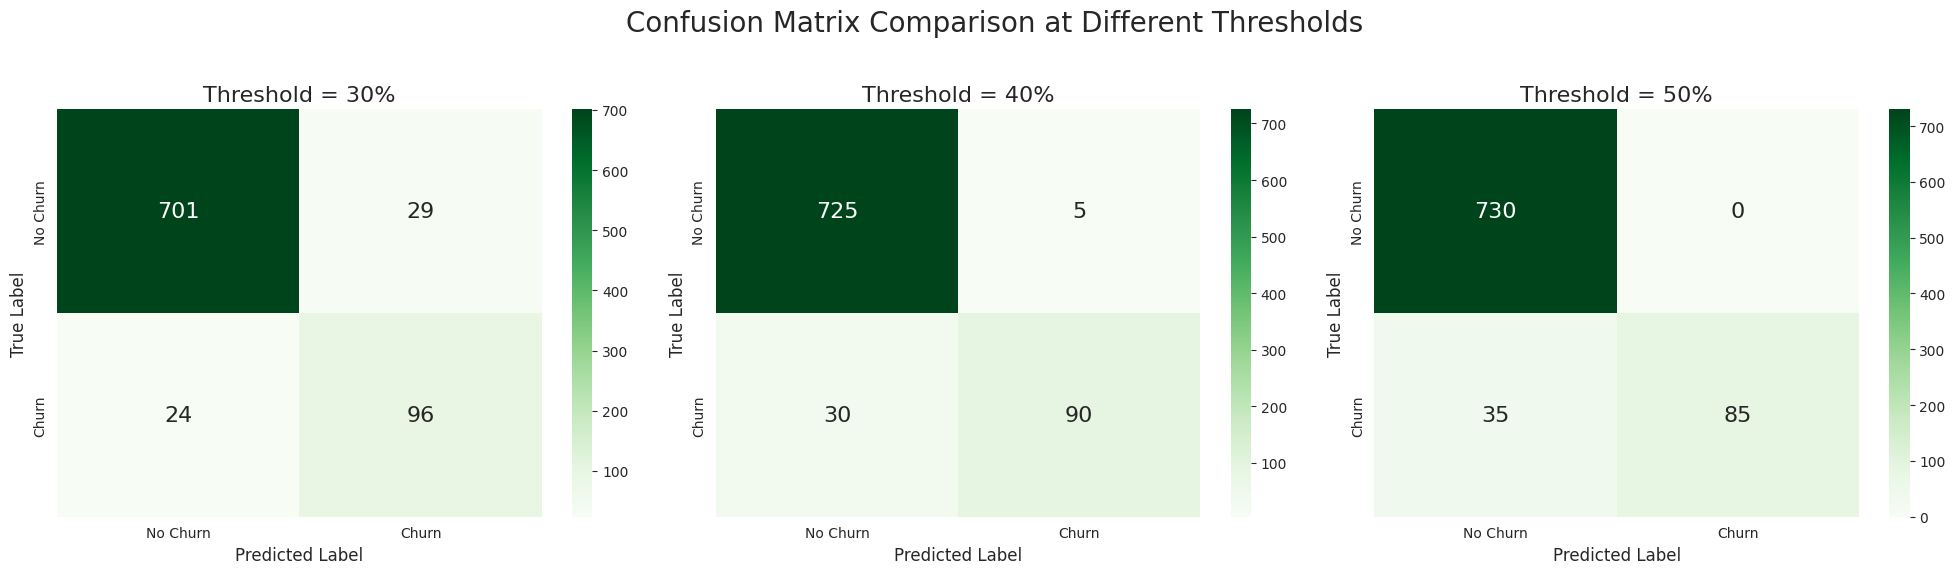

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# We already have the predicted probabilities
# y_pred_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

# Define the thresholds we want to compare
thresholds = [0.3, 0.4, 0.5]

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Confusion Matrix Comparison at Different Thresholds', fontsize=20)

for i, threshold in enumerate(thresholds):
    # Get predictions for the current threshold
    y_pred_custom = (y_pred_probs >= threshold).astype(int)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred_custom)

    # Create a heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[i],
                xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'],
                annot_kws={"size": 16})

    # Style the subplot
    axes[i].set_title(f'Threshold = {threshold*100:.0f}%', fontsize=16)
    axes[i].set_xlabel('Predicted Label', fontsize=12)
    axes[i].set_ylabel('True Label', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4. The Gains Chart (or Lift Chart)
* **Objective:** To provide a clear, intuitive visualization of the model's business value. This chart shows how much more efficient our model is at finding churners compared to randomly selecting customers to contact.

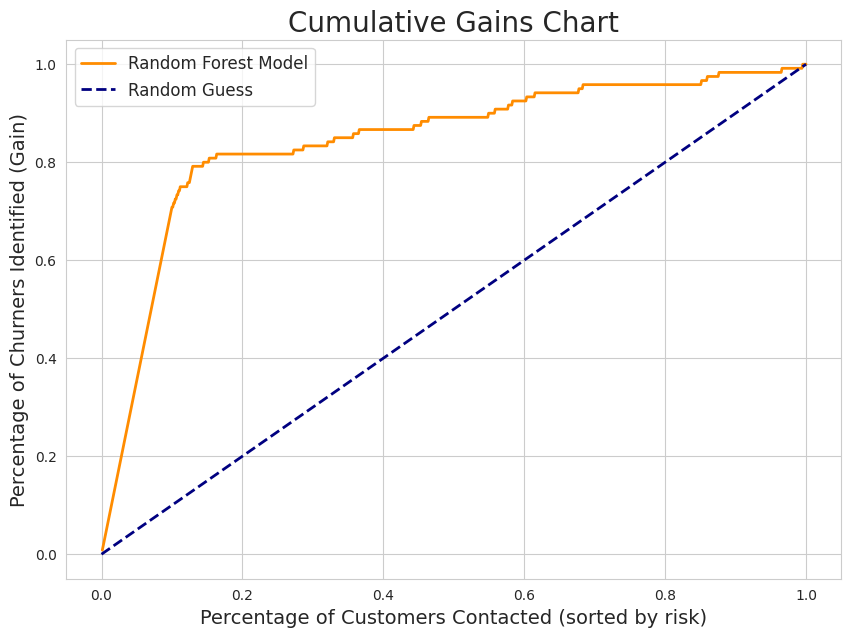

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# We use the raw probabilities before applying a threshold
y_probas = rf_model.predict_proba(X_test_scaled)[:, 1] # Probability of being a churner

# --- Manual Calculation for Gains Chart ---
# 1. Create a DataFrame with true values and predicted probabilities
df_gains = pd.DataFrame({'true_churn': y_test, 'predicted_prob': y_probas})

# 2. Sort customers from highest risk to lowest risk
df_gains = df_gains.sort_values(by='predicted_prob', ascending=False)

# 3. Calculate the cumulative number of churners found
df_gains['cumulative_churn'] = df_gains['true_churn'].cumsum()

# 4. Calculate the percentage of churners found (the "gain")
total_churners = df_gains['true_churn'].sum()
df_gains['gain'] = df_gains['cumulative_churn'] / total_churners

# 5. Calculate the percentage of customers contacted
df_gains['percentage_customers'] = np.arange(1, len(df_gains) + 1) / len(df_gains)


# --- Create the Visualization ---
plt.figure(figsize=(10, 7))
# Plot the model's performance
plt.plot(df_gains['percentage_customers'], df_gains['gain'], color='darkorange', lw=2, label='Random Forest Model')
# Plot the baseline "random guess"
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Style the plot
plt.title('Cumulative Gains Chart', fontsize=20)
plt.xlabel('Percentage of Customers Contacted (sorted by risk)', fontsize=14)
plt.ylabel('Percentage of Churners Identified (Gain)', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# Final Conclusion & Recommendations

This project successfully transitioned from raw data to a clear, data-driven strategy for reducing customer churn. By combining exploratory analysis, customer segmentation, and predictive modeling, we have not only identified the customers at risk but also understood the core reasons *why* they are leaving.

---

### Key Project Outcome: A High-Performing Early-Warning System

We have developed a **Random Forest model** that serves as a highly effective "early-warning system." After fine-tuning, this model can:

* **Successfully identify 75%** of all customers who are going to churn (75% Recall).
* Be **incredibly efficient**, with its predictions being **95% accurate** (95% Precision).

The model's decisions are driven by logical, understandable customer behaviors, with the most important predictors being **Total Day Minutes**, **Number of Customer Service Calls**, and the **International Plan**.

---

### Strategic Recommendations for the Business

Based on these findings, we recommend the following prioritized actions:

**1. Deploy the Predictive Model Immediately:**
* **Action:** Implement the tuned Random Forest model to run daily on all customers.
* **Business Impact:** This will generate a daily list of high-risk customers, allowing the retention team to move from a reactive to a **proactive** strategy.

**2. Launch a "High-Alert" Intervention Program for Frustrated Customers:**
* **Action:** Create an automated alert for any customer who makes their **4th call** to customer service. This customer should be immediately flagged as "critical risk" and routed to a specialized senior retention agent.
* **Business Impact:** Our analysis shows this is the single biggest tipping point for churn (50.7% churn rate). Intervening at this precise moment offers the highest chance of saving a dissatisfied customer.

**3. Conduct an Urgent Review of the International Plan:**
* **Action:** Launch a full business review of this product. Analyze its pricing, call quality, and value proposition against competitors. Survey the "At-Risk International" customer segment to understand their pain points directly.
* **Business Impact:** This plan is the biggest product-related driver of churn (42.2% churn rate). Fixing or repositioning this product is critical to long-term churn reduction.

**4. Nurture and Learn from the "Loyal Core":**
* **Action:** Recognize the `voice_mail_plan` users as your most loyal customer segment (7.4% churn rate). Analyze this group further to understand their demographics and other shared characteristics.
* **Business Impact:** By understanding what makes your most loyal customers happy, you can create targeted marketing campaigns to attract more customers like them and implement loyalty programs that cater to their needs.

By implementing these data-driven strategies, the business has a clear path to significantly reduce customer churn, increase customer lifetime value, and gain a competitive edge in the market.